In [1]:
import copy
from itertools import product
from classification_refined import classify
from processing import *
from readfiles import *
from decision import filter_summary
from subgraphclass import make_solver_summary
from sklearn.model_selection import train_test_split
from classification_refined import *
import networkx as nx
from readfiles import *
from metrics import *
import numpy as np
import networkx as nx
import time 
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from readfiles import corresp_label_file
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import concurrent.futures
import time
from functools import partial
import os


In [2]:
num = 84  # number of nodes in the graph
tri = int(num * (num + 1) * 0.5)  # we want only the upper diagonal due to symettry of connections
mat = np.triu_indices(84)
mews = '/home/skapoor/Thesis/gmwcs-solver'

In [3]:
target, feature, edge, solver_node_wts = 'NEOFAC_E', 'num_streamlines', 'pearson','const'
val, thresh, max_num_nodes, per = -0.01, 0, 10, 1.15
choice, classifier, refit_metric, feature_selection = 'random', 'ridge_reg', 'balanced_accuracy', 'baseline'
baseline_cases, self_loops = set(), False

In [4]:
# note: right now the matrix whole is not scaled, for computing the fscores and correlation coeff it has to be so.
y_train, y_test = computed_subjects(), test_subjects()
y_train_l, y_test_l = y_train[target], y_test[target]
X_train = generate_combined_matrix(tri, list(y_train.index))  # need to check indices till here then convert to numpy array
X_test = generate_test_data(tri, y_test.index)
X_train_l, X_test_l = edge_filtering(feature, X_train, X_test)
X, y = X_train_l.append(X_test_l), y_train_l.append(y_test_l)

In [5]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
y_binned = np.array(pd.qcut(y, 4, retbins=False, labels=range(4)))

In [6]:
skf.get_n_splits(X, y_binned)
print(skf, '-'*100)
results_solver = []
avg_thresh, self_loops = False, False
refit_metric = 'balanced_accuracy'
nodes = []
node_names = []
i =0 
param_grid = [{'alpha': [10, 1e3]}]
for train_index, test_index in skf.split(X, y_binned):
    i+=1
    start = time.time()
    #print("TRAIN:",len(train_index), train_index, "TEST:", len(test_index),test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train, X_test, arr = process_raw(X_train, X_test, y_train, edge)
    graph = np.zeros((84,84))

    for k,j ,l in zip(np.triu_indices(84)[0], np.triu_indices(84)[1], range(tri)):
        graph[k,j] = abs(arr.iloc[l]) #  taking the absolute value of the pearson correlation 
    # graph is currently upper triangular and needs to be converted into full matrix
    graph = graph + graph.transpose() - np.diag(graph.diagonal())
    graph = pd.DataFrame(graph, index = corresp_label_file('fs_default.txt').values(), 
                 columns = corresp_label_file('fs_default.txt').values())
    while len(graph.iloc[0]) > 15:
        node = graph.sum(axis=1).argmin()
        graph = graph.drop([graph.iloc[node].name])
        graph = graph.drop(graph.iloc[:, node].name, axis=1)
    node_names.extend(list(graph.columns))
    end = time.time()
    t = end - start
    print(f'Time for fold {i}:', round(t,3))
    

StratifiedKFold(n_splits=5, random_state=None, shuffle=True) ----------------------------------------------------------------------------------------------------
Time for fold 1: 3.782
Time for fold 2: 3.675
Time for fold 3: 3.642
Time for fold 4: 3.679
Time for fold 5: 3.701


In [7]:
dict(pd.Series(node_names).value_counts())

{'ctx-rh-rostralmiddlefrontal': 4,
 'Left-Cerebellum-Cortex': 4,
 'ctx-lh-isthmuscingulate': 4,
 'ctx-rh-postcentral': 3,
 'ctx-rh-caudalmiddlefrontal': 3,
 'ctx-lh-caudalmiddlefrontal': 3,
 'ctx-lh-rostralmiddlefrontal': 3,
 'ctx-rh-paracentral': 3,
 'ctx-lh-precentral': 3,
 'ctx-rh-posteriorcingulate': 2,
 'Right-Amygdala': 2,
 'Left-Thalamus-Proper': 2,
 'ctx-rh-cuneus': 2,
 'ctx-rh-insula': 2,
 'Right-Cerebellum-Cortex': 2,
 'ctx-rh-isthmuscingulate': 2,
 'ctx-rh-rostralanteriorcingulate': 2,
 'Right-Putamen': 2,
 'ctx-rh-parstriangularis': 2,
 'Left-Hippocampus': 1,
 'ctx-rh-caudalanteriorcingulate': 1,
 'ctx-rh-fusiform': 1,
 'ctx-lh-insula': 1,
 'ctx-lh-posteriorcingulate': 1,
 'ctx-lh-postcentral': 1,
 'ctx-rh-parsopercularis': 1,
 'ctx-lh-parsorbitalis': 1,
 'ctx-lh-superiorparietal': 1,
 'ctx-lh-transversetemporal': 1,
 'ctx-rh-medialorbitofrontal': 1,
 'ctx-lh-entorhinal': 1,
 'ctx-lh-inferiorparietal': 1,
 'ctx-rh-inferiorparietal': 1,
 'ctx-lh-pericalcarine': 1,
 'ctx-rh-p

In [8]:
len(pd.Series(node_names).unique())

44

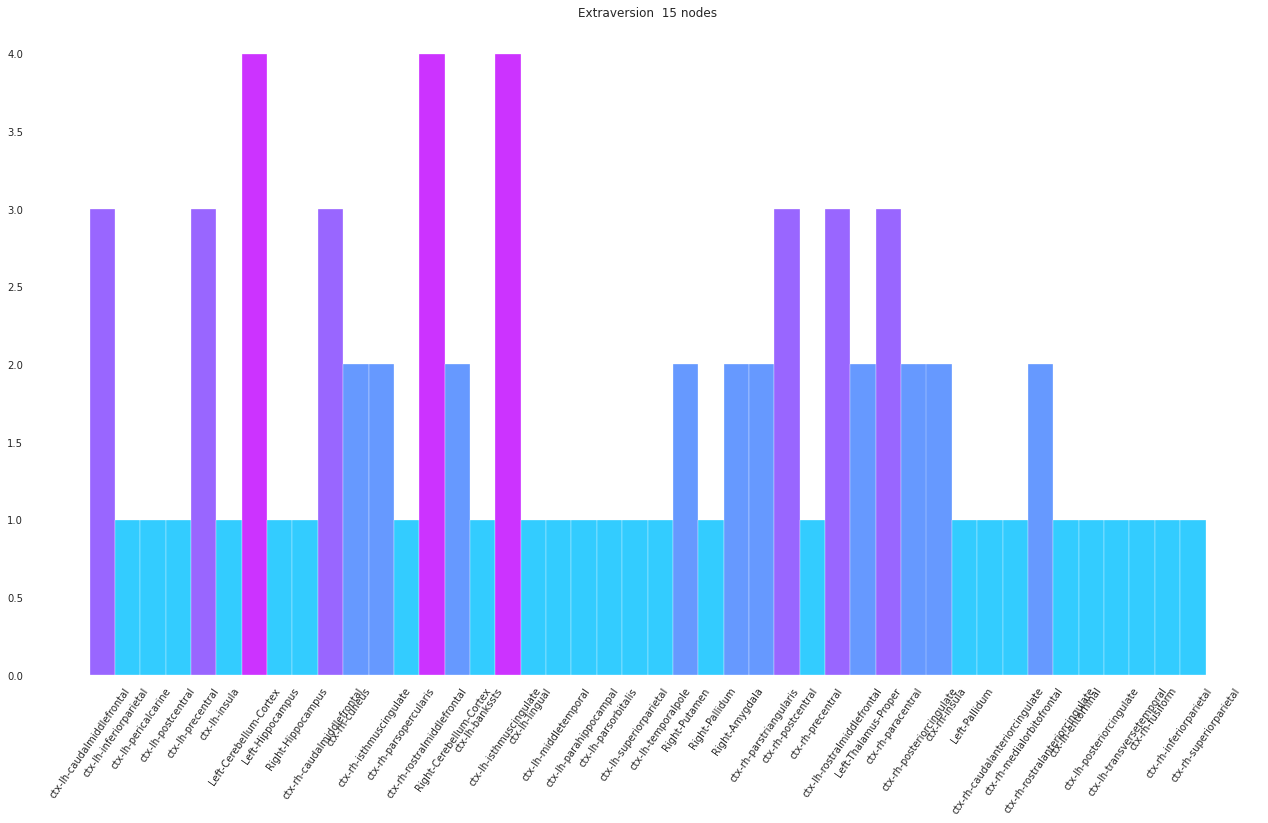

In [9]:
cm = plt.cm.get_cmap('cool')
fig, ax = plt.subplots(figsize=(22,12))
counts, bins, patches = ax.hist(node_names, bins=len(pd.Series(node_names).unique()))

for c, p in zip(counts, patches):
    plt.setp(p, 'facecolor', cm(c/5))
# Set the ticks to be at the edges of the bins.

plt.xticks(range(len(pd.Series(node_names).unique())), rotation = 55)
plt.title('Extraversion  15 nodes')
plt.show()